In [1]:
import sys
sys.path.append('./../../')

from tools import getdata, rms, masks
from astropy import units as u 
from astropy.io import fits
import matplotlib.pyplot as plt
import spectral_cube
import numpy as np
import warnings
import scipy
warnings.filterwarnings('ignore')

In [2]:
# Load data 
inputfile = '/Users/abarnes/Dropbox/work/Smallprojects/aces/data/alma/12m7mtp_lowres/HNCO_7m12mTP_CubeMosaic_downsample9.fits'

hdu = fits.open(inputfile)[0]
hdu.header['BUNIT'] = 'Jy/Beam'
cube = getdata.get_cube(hdu)
# cube = cube[:800]

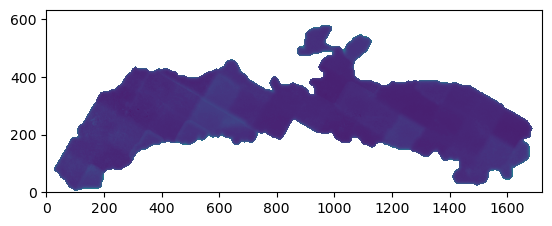

In [3]:
# Get noise
rms_map1 = rms.get_rmsrob(cube)
rms_map2 = rms.get_rms(cube, [[-140, -90],[90, 140]])
rms_map1.data = np.float32(rms_map1.data)
rms_map2.data = np.float32(rms_map2.data)
rms_map1.data[np.isnan(rms_map1.data)] = rms_map2.data[np.isnan(rms_map1.data)]

plt.imshow(rms_map1.data, origin='lower')

In [4]:
# Get mask
mask = masks.get_expmask(cube, rms_map1, hthresh=5, lthresh=2, npix=15)
cube_masked = cube.with_mask(mask)
cube_revmasked = cube.with_mask(~mask)

In [5]:
# fits.PrimaryHDU((mask)*1, rms_map1.header).writeto(inputfile.replace('.fits', '.mask.fits'), overwrite=True)
# fits.PrimaryHDU((~mask)*1, rms_map1.header).writeto(inputfile.replace('.fits', '.revmask.fits'), overwrite=True)

# cube_masked.write(inputfile.replace('.fits', '.masked.fits'), overwrite=True)
# cube_revmasked.write(inputfile.replace('.fits', '.revmasked.fits'), overwrite=True)

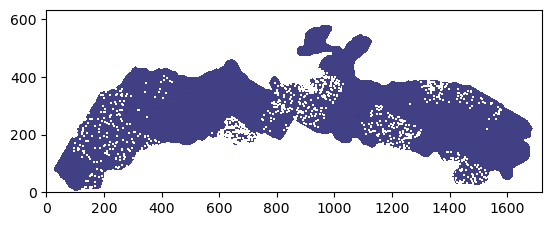

In [6]:
# Do contsub 
# data_cont = np.nanmean(cube_revmasked, axis=0)
data_cont = np.nanmedian(cube_revmasked, axis=0)
data_cont[data_cont == 0] = np.nan
hdu_cont = fits.PrimaryHDU(data_cont, rms_map1.header)
# hdu_cont.writeto(inputfile.replace('.fits', '.cont.fits'), overwrite=True)
plt.imshow(data_cont, origin='lower')

hdu_contsub = cube.hdu.copy() 
hdu_contsub.data = hdu_contsub.data - data_cont
hdu_contsub.data = np.float32(hdu_contsub.data)
# hdu_contsub.writeto(inputfile.replace('.fits', '.contsub.fits'), overwrite=True)

In [8]:
cube_contsub = getdata.get_cube(hdu_contsub) 
cube_contsub_masked = cube_contsub.with_mask(mask)

cube_contsub_masked.allow_huge_operations=True
mom_max = cube_contsub_masked.max(axis=(0))
mom_max.write(inputfile.replace('.fits', '.contsub.masked.max.fits'), overwrite=True)